# ANBW_v3
- To do
    - Improve model performance
    - Reusable Pipeline Configuration
    - Apply appropriate garbage collecting

## Setup

In [1]:
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = "3"

In [2]:
import gc
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

In [3]:
print("CUDA avilable:",
     True if tf.config.list_physical_devices("GPU") else False)

CUDA avilable: True


In [4]:
SEED = 1234
np.random.seed(SEED)
tf.random.set_seed(SEED)

## Load data

In [5]:
train = pd.read_csv("./dataset/train.csv")
test = pd.read_csv("./dataset/test.csv")
# submission = pd.read_csv("./dataset/submission.csv")

In [6]:
img_save_path = "./img/v3/"

if not(os.path.isdir(img_save_path)):
    os.makedirs(os.path.join(img_save_path))
    print("Directory Created: %s" % img_save_path)
else:
    print("Directory already exists: %s" % img_save_path)

Directory already exists: ./img/v3/


## EDA

### Plot saving function

In [7]:
def save_plot(img_path: str) -> None:
    if not(os.path.isfile(img_path)):
        plt.savefig(img_path, facecolor="#eeeeee", bbox_inches="tight")
        print("successfully image saved: %s" % img_path)
    else:
        print("Directory already exists: %s" % img_path)

### Train data

In [8]:
train.set_index("id").head()

,digit,letter,0,1,2,3,4,5,6,7,...,774,775,776,777,778,779,780,781,782,783
id,,,,,,,,,,,,,,,,,,,,,
1,5,L,1,1,1,4,3,0,0,4,...,2,1,0,1,2,4,4,4,3,4
2,0,B,0,4,0,0,4,1,1,1,...,0,3,0,1,4,1,4,2,1,2
3,4,L,1,1,2,2,1,1,1,0,...,3,3,3,0,2,0,3,0,2,2
4,9,D,1,2,0,2,0,4,0,3,...,3,3,2,0,1,4,0,0,1,1
5,6,A,3,0,2,4,0,3,0,4,...,4,4,3,2,1,3,4,3,1,2


In [9]:
train_digit_cnt = train["digit"].value_counts(normalize=False, sort=False).values
train_digit_label = sorted(train["digit"].unique())

Directory already exists: ./img/v3/train_digit_distribution.png


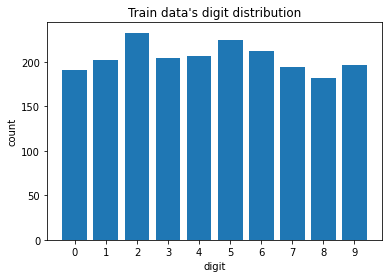

In [10]:
plt.bar(train_digit_label, train_digit_cnt)
plt.title("Train data's digit distribution")
plt.xticks(train_digit_label)
plt.xlabel("digit")
plt.ylabel("count")

img_path = img_save_path + "train_digit_distribution.png"
save_plot(img_path)

In [11]:
train.shape

(2048, 787)

### Test data

In [12]:
test.set_index("id").head()

,letter,0,1,2,3,4,5,6,7,8,...,774,775,776,777,778,779,780,781,782,783
id,,,,,,,,,,,,,,,,,,,,,
2049,L,0,4,0,2,4,2,3,1,0,...,2,0,4,2,2,4,3,4,1,4
2050,C,4,1,4,0,1,1,0,2,2,...,0,3,2,4,2,4,2,2,1,2
2051,S,0,4,0,1,3,2,3,0,2,...,1,3,2,0,3,2,3,0,1,4
2052,K,2,1,3,3,3,4,3,0,0,...,3,0,3,2,4,1,0,4,4,4
2053,W,1,0,1,1,2,2,1,4,1,...,4,3,1,4,0,2,1,2,3,4


In [13]:
test.shape

(20480, 786)

### Data visualization

Directory already exists: ./img/v3/train_visualize.png


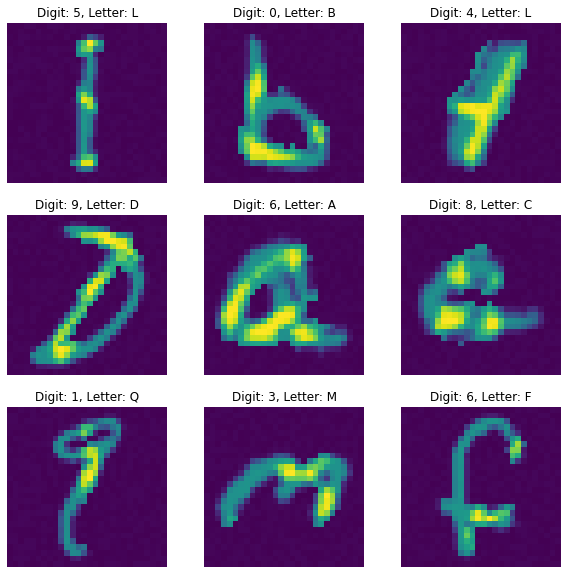

In [14]:
plt.figure(figsize=(10, 10))
for idx in range(9):
    ax = plt.subplot(3, 3, idx+1)
    img = train.loc[idx, "0": ].values.reshape(28, 28).astype(int)
    plt.imshow(img)
    plt.title("Digit: %s, Letter: %s" % (train.loc[idx, "digit"], train.loc[idx, "letter"]))
    plt.axis("off")

img_path = img_save_path + "train_visualize.png"
save_plot(img_path)

In [15]:
del ax, idx, img, img_path, img_save_path, train_digit_cnt, train_digit_label
gc.collect()

26480

## Data preprocessing & Set Hyper-parameter

In [16]:
BATCH = 4
EPOCHS = 100
BUFFER_SIZE = 2048

In [17]:
x_train = train.drop(["id", "digit", "letter"], axis=1).values
x_train = x_train.reshape(-1, 28, 28, 1)

x_train = np.where((x_train<=20)&(x_train!=0) ,0.,x_train)
x_train = x_train/255
x_train = x_train.astype("float32")

In [18]:
y = train["digit"]
y_train = np.zeros((len(y), len(y.unique())))

for idx, digit in enumerate(y):
    y_train[idx, digit] = 1

In [19]:
x_train_resized = np.zeros([2048, 300, 300, 3], dtype=np.float32)

In [20]:
for idx, img in enumerate(x_train):
    converted = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    resized = cv2.resize(converted, (300, 300), interpolation=cv2.INTER_CUBIC)
    del converted
    x_train_resized[idx] = resized
    del resized
    gc.collect()

In [21]:
x_train, x_valid, y_train, y_valid = train_test_split(x_train_resized, y_train, test_size=0.2, random_state=SEED, shuffle=True)

In [23]:
del x_train_resized, y, idx
gc.collect()

NameError: name 'x_train_resized' is not defined

In [ ]:
def train_validation_generator(path: str, fraction: float) -> (tf.float32, tf.float32):
    """
    Train/Validation Image data preproccesing and generating
    1. Read CSV file with Pandas and split data to train/data
    2. Slice the feature data(pixels) and label(digit)
    3. Convert Color from grayscale to RGB
    4. Resize image from (28, 28) to (300, 300)
    5. Convert labels to one hot encoding array and return with preprocessed image
    """    
    raw_data = pd.read_csv(path, engine="python")
    raw_data = raw_data.sample(frac=fraction, random_state=SEED)
    
    features = raw_data.drop(["id", "digit", "letter"], axis=1).values
    features = features.reshape(-1, 28, 28, 1)
    features = np.where((features<=20)&(features!=0), 0., features)
    features = features / 255
    features = features.astype("float32")
    
    labels = raw_data["digit"]
    
    for feat, label in zip(features, labels):
        cvt_feat = cv2.cvtColor(feat, cv2.COLOR_GRAY2RGB)
        resized_feat = cv2.resize(cvt_feat, (300, 300), interpolation=cv2.INTER_CUBIC)
        label = tf.keras.utils.to_categorical(label, 10)
        
        yield(resized_feat, label)

In [ ]:
def test_generator(path: str) -> (tf.float32):
    """
    Test Image data preproccesing and generating
    1. Read CSV file with Pandas
    2. Slice the feature data(pixels)
    3. Convert Color from grayscale to RGB
    4. Resize image from (28, 28) to (300, 300)
    5. Return preprocessed image
    """
    raw_data = pd.read_csv(path, engine="python")
    
    features = raw_data.drop(["id", "digit", "letter"], axis=1).values
    features = features.reshape(-1, 28, 28, 1)
    features = np.where((features<=20)&(features!=0), 0., features)
    features = features / 255
    features = features.astype("float32")
    
    for feat in features:
        cvt_feat = cv2.cvtColor(feat, cv2.COLOR_GRAY2RGB)
        resized_feat = cv2.resize(cvt_feat, (300, 300), interpolation=cv2.INTER_CUBIC)
        
        yield(resized_feat)

In [ ]:
# Have to give args to generator with using lambda
# Train: 0.8
# Validation: 0.2

train_dataset = tf.data.Dataset.from_generator(
    lambda: train_validation_generator(path="./dataset/train.csv", fraction=0.8),
    (tf.float32, tf.float32),
    ([300, 300, 3], [10])
)
train_dataset = train_dataset.batch(BATCH).shuffle(buffer_size=BUFFER_SIZE, seed=SEED)

validation_dataset = tf.data.Dataset.from_generator(
    lambda: train_validation_generator(path="./dataset/train.csv", fraction=0.2),
    (tf.float32, tf.float32),
    ([300, 300, 3], [10])
)
validation_dataset = validation_dataset.batch(BATCH).shuffle(buffer_size=BUFFER_SIZE, seed=SEED)

test_dataset = tf.data.Dataset.from_generator(
    lambda: test_generator(path="./dataset/test.csv"),
    (tf.float32),
    ([300, 300, 3])
)
test_dataset = test_dataset.batch(BATCH).shuffle(buffer_size=BUFFER_SIZE, seed=SEED)

## Initialing model

In [25]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [26]:
model_save_dir = "./model/v3/"

if not(os.path.isdir(model_save_dir)):
    os.makedirs(os.path.join(model_save_dir))
    print("Directory Created: %s" % model_save_dir)
else:
    print("Directory already exists: %s" % model_save_dir)

Directory Created: ./model/v3/


In [29]:
model_save_path = model_save_dir + "/ckp-epoch-{epoch:02d}.h5"
model_checkpoint_callback = ModelCheckpoint(
    filepath=model_save_path,
    monitor="val_accuracy",
    save_best_only=True,
    save_freq=5,
    verbose=1
)

early_stopping = EarlyStopping(monitor="val_loss", verbose=1, patience=10),

reduce_LR = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=1,
                      min_lr=0.00001, verbose=1, mode="min")

In [28]:
CALLBACKS = [
    model_checkpoint_callback,
    early_stopping,
    reduce_LR
]

In [30]:
effnet = tf.keras.applications.EfficientNetB3(
    include_top=True,
    weights=None,
    input_shape=(300, 300, 3),
    classes=10,
    classifier_activation="softmax",
)

In [31]:
model = tf.keras.Sequential()
model.add(effnet)

model.compile(loss="categorical_crossentropy",
             optimizer="RMSprop",
             metrics=["accuracy"])

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb3 (Functional)  (None, 10)                10798905  
Total params: 10,798,905
Trainable params: 10,711,602
Non-trainable params: 87,303
_________________________________________________________________


In [34]:
history = model.fit(
    x_train, 
    y_train, 
    batch_size=BATCH, 
    epochs=EPOCHS, 
    callbacks=CALLBACKS, 
    validation_data=(x_valid, y_valid)
)

"""
history = model.fit(train_dataset,
                    batch_size=BATCH,
                    epochs=EPOCHS,
                    callbacks=CALLBACKS,
                    validation_data=validation_dataset)
"""

Epoch 1/100
  1/410 [..............................] - ETA: 0s - loss: 5.0018 - accuracy: 0.2500
Epoch 00001: saving model to ./model/v3\ckp-epoch-01.h5
  6/410 [..............................] - ETA: 2:38 - loss: 10.2896 - accuracy: 0.1667
Epoch 00001: saving model to ./model/v3\ckp-epoch-01.h5
 11/410 [..............................] - ETA: 2:51 - loss: 9.9466 - accuracy: 0.1364 
Epoch 00001: saving model to ./model/v3\ckp-epoch-01.h5
 16/410 [>.............................] - ETA: 2:54 - loss: 8.6425 - accuracy: 0.2188
Epoch 00001: saving model to ./model/v3\ckp-epoch-01.h5
 21/410 [>.............................] - ETA: 2:55 - loss: 7.8805 - accuracy: 0.2024
Epoch 00001: saving model to ./model/v3\ckp-epoch-01.h5
 26/410 [>.............................] - ETA: 2:55 - loss: 7.1937 - accuracy: 0.2019
Epoch 00001: saving model to ./model/v3\ckp-epoch-01.h5
 31/410 [=>............................] - ETA: 2:54 - loss: 6.7972 - accuracy: 0.1774
Epoch 00001: saving model to ./model/v3\ckp

276/410 [===================>..........] - ETA: 1:04 - loss: 3.1947 - accuracy: 0.1132
Epoch 00001: saving model to ./model/v3\ckp-epoch-01.h5
281/410 [===================>..........] - ETA: 1:01 - loss: 3.1833 - accuracy: 0.1148
Epoch 00001: saving model to ./model/v3\ckp-epoch-01.h5
286/410 [===================>..........] - ETA: 59s - loss: 3.1664 - accuracy: 0.1163
Epoch 00001: saving model to ./model/v3\ckp-epoch-01.h5
291/410 [====================>.........] - ETA: 57s - loss: 3.1578 - accuracy: 0.1143
Epoch 00001: saving model to ./model/v3\ckp-epoch-01.h5
296/410 [====================>.........] - ETA: 54s - loss: 3.1462 - accuracy: 0.1157
Epoch 00001: saving model to ./model/v3\ckp-epoch-01.h5
301/410 [=====================>........] - ETA: 52s - loss: 3.1329 - accuracy: 0.1154
Epoch 00001: saving model to ./model/v3\ckp-epoch-01.h5
306/410 [=====================>........] - ETA: 49s - loss: 3.1191 - accuracy: 0.1160
Epoch 00001: saving model to ./model/v3\ckp-epoch-01.h5
311/

146/410 [=========>....................] - ETA: 2:06 - loss: 2.4596 - accuracy: 0.1096
Epoch 00002: saving model to ./model/v3\ckp-epoch-02.h5
151/410 [==========>...................] - ETA: 2:04 - loss: 2.4567 - accuracy: 0.1093
Epoch 00002: saving model to ./model/v3\ckp-epoch-02.h5
156/410 [==========>...................] - ETA: 2:01 - loss: 2.4505 - accuracy: 0.1106
Epoch 00002: saving model to ./model/v3\ckp-epoch-02.h5
161/410 [==========>...................] - ETA: 1:59 - loss: 2.4436 - accuracy: 0.1149
Epoch 00002: saving model to ./model/v3\ckp-epoch-02.h5
166/410 [===========>..................] - ETA: 1:57 - loss: 2.4386 - accuracy: 0.1160
Epoch 00002: saving model to ./model/v3\ckp-epoch-02.h5
171/410 [===========>..................] - ETA: 1:54 - loss: 2.4355 - accuracy: 0.1170
Epoch 00002: saving model to ./model/v3\ckp-epoch-02.h5
176/410 [===========>..................] - ETA: 1:52 - loss: 2.4319 - accuracy: 0.1165
Epoch 00002: saving model to ./model/v3\ckp-epoch-02.h5

 16/410 [>.............................] - ETA: 3:03 - loss: 2.3838 - accuracy: 0.1562
Epoch 00003: saving model to ./model/v3\ckp-epoch-03.h5
 21/410 [>.............................] - ETA: 3:03 - loss: 2.3629 - accuracy: 0.1548
Epoch 00003: saving model to ./model/v3\ckp-epoch-03.h5
 26/410 [>.............................] - ETA: 3:07 - loss: 2.3851 - accuracy: 0.1250
Epoch 00003: saving model to ./model/v3\ckp-epoch-03.h5
 31/410 [=>............................] - ETA: 3:05 - loss: 2.3783 - accuracy: 0.1210
Epoch 00003: saving model to ./model/v3\ckp-epoch-03.h5
 36/410 [=>............................] - ETA: 3:02 - loss: 2.4129 - accuracy: 0.1181
Epoch 00003: saving model to ./model/v3\ckp-epoch-03.h5
 41/410 [==>...........................] - ETA: 2:59 - loss: 2.4027 - accuracy: 0.1220
Epoch 00003: saving model to ./model/v3\ckp-epoch-03.h5
 46/410 [==>...........................] - ETA: 2:57 - loss: 2.4001 - accuracy: 0.1196
Epoch 00003: saving model to ./model/v3\ckp-epoch-03.h5

301/410 [=====================>........] - ETA: 52s - loss: 2.3910 - accuracy: 0.1163
Epoch 00003: saving model to ./model/v3\ckp-epoch-03.h5
306/410 [=====================>........] - ETA: 50s - loss: 2.3895 - accuracy: 0.1168
Epoch 00003: saving model to ./model/v3\ckp-epoch-03.h5
311/410 [=====================>........] - ETA: 47s - loss: 2.3873 - accuracy: 0.1158
Epoch 00003: saving model to ./model/v3\ckp-epoch-03.h5
316/410 [======================>.......] - ETA: 45s - loss: 2.3879 - accuracy: 0.1163
Epoch 00003: saving model to ./model/v3\ckp-epoch-03.h5
321/410 [======================>.......] - ETA: 43s - loss: 2.3889 - accuracy: 0.1160
Epoch 00003: saving model to ./model/v3\ckp-epoch-03.h5
326/410 [======================>.......] - ETA: 40s - loss: 2.3889 - accuracy: 0.1166
Epoch 00003: saving model to ./model/v3\ckp-epoch-03.h5
331/410 [=======================>......] - ETA: 38s - loss: 2.3876 - accuracy: 0.1171
Epoch 00003: saving model to ./model/v3\ckp-epoch-03.h5
336/41

171/410 [===========>..................] - ETA: 1:54 - loss: 2.2482 - accuracy: 0.1944
Epoch 00004: saving model to ./model/v3\ckp-epoch-04.h5
176/410 [===========>..................] - ETA: 1:52 - loss: 2.2488 - accuracy: 0.1960
Epoch 00004: saving model to ./model/v3\ckp-epoch-04.h5
181/410 [============>.................] - ETA: 1:50 - loss: 2.2490 - accuracy: 0.1961
Epoch 00004: saving model to ./model/v3\ckp-epoch-04.h5
186/410 [============>.................] - ETA: 1:48 - loss: 2.2448 - accuracy: 0.1962
Epoch 00004: saving model to ./model/v3\ckp-epoch-04.h5
191/410 [============>.................] - ETA: 1:45 - loss: 2.2440 - accuracy: 0.1950
Epoch 00004: saving model to ./model/v3\ckp-epoch-04.h5
196/410 [=============>................] - ETA: 1:43 - loss: 2.2382 - accuracy: 0.2015
Epoch 00004: saving model to ./model/v3\ckp-epoch-04.h5
201/410 [=============>................] - ETA: 1:40 - loss: 2.2434 - accuracy: 0.1978
Epoch 00004: saving model to ./model/v3\ckp-epoch-04.h5

 41/410 [==>...........................] - ETA: 2:52 - loss: 1.9090 - accuracy: 0.3171
Epoch 00005: saving model to ./model/v3\ckp-epoch-05.h5
 46/410 [==>...........................] - ETA: 2:50 - loss: 1.9135 - accuracy: 0.3261
Epoch 00005: saving model to ./model/v3\ckp-epoch-05.h5
 51/410 [==>...........................] - ETA: 2:50 - loss: 1.9288 - accuracy: 0.3186
Epoch 00005: saving model to ./model/v3\ckp-epoch-05.h5
 56/410 [===>..........................] - ETA: 2:48 - loss: 1.9593 - accuracy: 0.3036
Epoch 00005: saving model to ./model/v3\ckp-epoch-05.h5
 61/410 [===>..........................] - ETA: 2:46 - loss: 1.9380 - accuracy: 0.3033
Epoch 00005: saving model to ./model/v3\ckp-epoch-05.h5
 66/410 [===>..........................] - ETA: 2:43 - loss: 1.9476 - accuracy: 0.3030
Epoch 00005: saving model to ./model/v3\ckp-epoch-05.h5
 71/410 [====>.........................] - ETA: 2:41 - loss: 1.9476 - accuracy: 0.2993
Epoch 00005: saving model to ./model/v3\ckp-epoch-05.h5

326/410 [======================>.......] - ETA: 40s - loss: 1.8790 - accuracy: 0.3497
Epoch 00005: saving model to ./model/v3\ckp-epoch-05.h5
331/410 [=======================>......] - ETA: 38s - loss: 1.8695 - accuracy: 0.3520
Epoch 00005: saving model to ./model/v3\ckp-epoch-05.h5
336/410 [=======================>......] - ETA: 35s - loss: 1.8735 - accuracy: 0.3497
Epoch 00005: saving model to ./model/v3\ckp-epoch-05.h5
341/410 [=======================>......] - ETA: 33s - loss: 1.8699 - accuracy: 0.3512
Epoch 00005: saving model to ./model/v3\ckp-epoch-05.h5
346/410 [========================>.....] - ETA: 30s - loss: 1.8682 - accuracy: 0.3512
Epoch 00005: saving model to ./model/v3\ckp-epoch-05.h5
351/410 [========================>.....] - ETA: 28s - loss: 1.8668 - accuracy: 0.3519
Epoch 00005: saving model to ./model/v3\ckp-epoch-05.h5
356/410 [=========================>....] - ETA: 26s - loss: 1.8660 - accuracy: 0.3525
Epoch 00005: saving model to ./model/v3\ckp-epoch-05.h5
361/41

196/410 [=============>................] - ETA: 1:42 - loss: 1.6364 - accuracy: 0.4452
Epoch 00006: saving model to ./model/v3\ckp-epoch-06.h5
201/410 [=============>................] - ETA: 1:40 - loss: 1.6357 - accuracy: 0.4415
Epoch 00006: saving model to ./model/v3\ckp-epoch-06.h5
206/410 [==============>...............] - ETA: 1:38 - loss: 1.6284 - accuracy: 0.4442
Epoch 00006: saving model to ./model/v3\ckp-epoch-06.h5
211/410 [==============>...............] - ETA: 1:35 - loss: 1.6194 - accuracy: 0.4491
Epoch 00006: saving model to ./model/v3\ckp-epoch-06.h5
216/410 [==============>...............] - ETA: 1:33 - loss: 1.6258 - accuracy: 0.4491
Epoch 00006: saving model to ./model/v3\ckp-epoch-06.h5
221/410 [===============>..............] - ETA: 1:30 - loss: 1.6267 - accuracy: 0.4491
Epoch 00006: saving model to ./model/v3\ckp-epoch-06.h5
226/410 [===============>..............] - ETA: 1:28 - loss: 1.6258 - accuracy: 0.4502
Epoch 00006: saving model to ./model/v3\ckp-epoch-06.h5

 66/410 [===>..........................] - ETA: 2:44 - loss: 1.3752 - accuracy: 0.5417
Epoch 00007: saving model to ./model/v3\ckp-epoch-07.h5
 71/410 [====>.........................] - ETA: 2:41 - loss: 1.3818 - accuracy: 0.5387
Epoch 00007: saving model to ./model/v3\ckp-epoch-07.h5
 76/410 [====>.........................] - ETA: 2:39 - loss: 1.3929 - accuracy: 0.5263
Epoch 00007: saving model to ./model/v3\ckp-epoch-07.h5
 81/410 [====>.........................] - ETA: 2:37 - loss: 1.3707 - accuracy: 0.5247
Epoch 00007: saving model to ./model/v3\ckp-epoch-07.h5
 86/410 [=====>........................] - ETA: 2:34 - loss: 1.4050 - accuracy: 0.5145
Epoch 00007: saving model to ./model/v3\ckp-epoch-07.h5
 91/410 [=====>........................] - ETA: 2:32 - loss: 1.3942 - accuracy: 0.5110
Epoch 00007: saving model to ./model/v3\ckp-epoch-07.h5
 96/410 [======>.......................] - ETA: 2:30 - loss: 1.3707 - accuracy: 0.5260
Epoch 00007: saving model to ./model/v3\ckp-epoch-07.h5

351/410 [========================>.....] - ETA: 28s - loss: 1.3283 - accuracy: 0.5605
Epoch 00007: saving model to ./model/v3\ckp-epoch-07.h5
356/410 [=========================>....] - ETA: 25s - loss: 1.3239 - accuracy: 0.5611
Epoch 00007: saving model to ./model/v3\ckp-epoch-07.h5
361/410 [=========================>....] - ETA: 23s - loss: 1.3214 - accuracy: 0.5602
Epoch 00007: saving model to ./model/v3\ckp-epoch-07.h5
366/410 [=========================>....] - ETA: 21s - loss: 1.3180 - accuracy: 0.5608
Epoch 00007: saving model to ./model/v3\ckp-epoch-07.h5
371/410 [==========================>...] - ETA: 18s - loss: 1.3184 - accuracy: 0.5627
Epoch 00007: saving model to ./model/v3\ckp-epoch-07.h5
376/410 [==========================>...] - ETA: 16s - loss: 1.3307 - accuracy: 0.5632
Epoch 00007: saving model to ./model/v3\ckp-epoch-07.h5
381/410 [==========================>...] - ETA: 13s - loss: 1.3277 - accuracy: 0.5643
Epoch 00007: saving model to ./model/v3\ckp-epoch-07.h5
386/41

221/410 [===============>..............] - ETA: 1:30 - loss: 1.1681 - accuracy: 0.6233
Epoch 00008: saving model to ./model/v3\ckp-epoch-08.h5
226/410 [===============>..............] - ETA: 1:27 - loss: 1.1793 - accuracy: 0.6217
Epoch 00008: saving model to ./model/v3\ckp-epoch-08.h5
231/410 [===============>..............] - ETA: 1:25 - loss: 1.1802 - accuracy: 0.6190
Epoch 00008: saving model to ./model/v3\ckp-epoch-08.h5
236/410 [================>.............] - ETA: 1:23 - loss: 1.1850 - accuracy: 0.6155
Epoch 00008: saving model to ./model/v3\ckp-epoch-08.h5
241/410 [================>.............] - ETA: 1:20 - loss: 1.1813 - accuracy: 0.6151
Epoch 00008: saving model to ./model/v3\ckp-epoch-08.h5
246/410 [=================>............] - ETA: 1:18 - loss: 1.1828 - accuracy: 0.6159
Epoch 00008: saving model to ./model/v3\ckp-epoch-08.h5
251/410 [=================>............] - ETA: 1:15 - loss: 1.1824 - accuracy: 0.6155
Epoch 00008: saving model to ./model/v3\ckp-epoch-08.h5

 86/410 [=====>........................] - ETA: 2:34 - loss: 0.8875 - accuracy: 0.7122
Epoch 00009: saving model to ./model/v3\ckp-epoch-09.h5
 91/410 [=====>........................] - ETA: 2:31 - loss: 0.9053 - accuracy: 0.7060
Epoch 00009: saving model to ./model/v3\ckp-epoch-09.h5
 96/410 [======>.......................] - ETA: 2:29 - loss: 0.8994 - accuracy: 0.7109
Epoch 00009: saving model to ./model/v3\ckp-epoch-09.h5
101/410 [======>.......................] - ETA: 2:27 - loss: 0.9113 - accuracy: 0.7079
Epoch 00009: saving model to ./model/v3\ckp-epoch-09.h5
106/410 [======>.......................] - ETA: 2:24 - loss: 0.9184 - accuracy: 0.7052
Epoch 00009: saving model to ./model/v3\ckp-epoch-09.h5
111/410 [=======>......................] - ETA: 2:22 - loss: 0.8898 - accuracy: 0.7185
Epoch 00009: saving model to ./model/v3\ckp-epoch-09.h5
116/410 [=======>......................] - ETA: 2:20 - loss: 0.8881 - accuracy: 0.7198
Epoch 00009: saving model to ./model/v3\ckp-epoch-09.h5

371/410 [==========================>...] - ETA: 18s - loss: 0.8401 - accuracy: 0.7392
Epoch 00009: saving model to ./model/v3\ckp-epoch-09.h5
376/410 [==========================>...] - ETA: 16s - loss: 0.8379 - accuracy: 0.7400
Epoch 00009: saving model to ./model/v3\ckp-epoch-09.h5
381/410 [==========================>...] - ETA: 13s - loss: 0.8337 - accuracy: 0.7408
Epoch 00009: saving model to ./model/v3\ckp-epoch-09.h5
386/410 [===========================>..] - ETA: 11s - loss: 0.8353 - accuracy: 0.7390
Epoch 00009: saving model to ./model/v3\ckp-epoch-09.h5
391/410 [===========================>..] - ETA: 9s - loss: 0.8358 - accuracy: 0.7391
Epoch 00009: saving model to ./model/v3\ckp-epoch-09.h5
396/410 [===========================>..] - ETA: 6s - loss: 0.8391 - accuracy: 0.7380
Epoch 00009: saving model to ./model/v3\ckp-epoch-09.h5
401/410 [============================>.] - ETA: 4s - loss: 0.8353 - accuracy: 0.7388
Epoch 00009: saving model to ./model/v3\ckp-epoch-09.h5
406/410 [

241/410 [================>.............] - ETA: 1:20 - loss: 0.7374 - accuracy: 0.7635
Epoch 00010: saving model to ./model/v3\ckp-epoch-10.h5
246/410 [=================>............] - ETA: 1:18 - loss: 0.7275 - accuracy: 0.7663
Epoch 00010: saving model to ./model/v3\ckp-epoch-10.h5
251/410 [=================>............] - ETA: 1:16 - loss: 0.7186 - accuracy: 0.7679
Epoch 00010: saving model to ./model/v3\ckp-epoch-10.h5
256/410 [=================>............] - ETA: 1:13 - loss: 0.7116 - accuracy: 0.7705
Epoch 00010: saving model to ./model/v3\ckp-epoch-10.h5
261/410 [==================>...........] - ETA: 1:11 - loss: 0.7123 - accuracy: 0.7711
Epoch 00010: saving model to ./model/v3\ckp-epoch-10.h5
266/410 [==================>...........] - ETA: 1:08 - loss: 0.7169 - accuracy: 0.7707
Epoch 00010: saving model to ./model/v3\ckp-epoch-10.h5
271/410 [==================>...........] - ETA: 1:06 - loss: 0.7106 - accuracy: 0.7712
Epoch 00010: saving model to ./model/v3\ckp-epoch-10.h5

111/410 [=======>......................] - ETA: 2:22 - loss: 0.6213 - accuracy: 0.7928
Epoch 00011: saving model to ./model/v3\ckp-epoch-11.h5
116/410 [=======>......................] - ETA: 2:20 - loss: 0.6081 - accuracy: 0.7953
Epoch 00011: saving model to ./model/v3\ckp-epoch-11.h5
121/410 [=======>......................] - ETA: 2:17 - loss: 0.6093 - accuracy: 0.7913
Epoch 00011: saving model to ./model/v3\ckp-epoch-11.h5
126/410 [========>.....................] - ETA: 2:15 - loss: 0.6030 - accuracy: 0.7937
Epoch 00011: saving model to ./model/v3\ckp-epoch-11.h5
131/410 [========>.....................] - ETA: 2:12 - loss: 0.6278 - accuracy: 0.7920
Epoch 00011: saving model to ./model/v3\ckp-epoch-11.h5
136/410 [========>.....................] - ETA: 2:10 - loss: 0.6272 - accuracy: 0.7941
Epoch 00011: saving model to ./model/v3\ckp-epoch-11.h5
141/410 [=========>....................] - ETA: 2:08 - loss: 0.6133 - accuracy: 0.8014
Epoch 00011: saving model to ./model/v3\ckp-epoch-11.h5

396/410 [===========================>..] - ETA: 6s - loss: 0.6408 - accuracy: 0.8056
Epoch 00011: saving model to ./model/v3\ckp-epoch-11.h5
401/410 [============================>.] - ETA: 4s - loss: 0.6395 - accuracy: 0.8067
Epoch 00011: saving model to ./model/v3\ckp-epoch-11.h5
406/410 [============================>.] - ETA: 1s - loss: 0.6405 - accuracy: 0.8054
Epoch 00011: saving model to ./model/v3\ckp-epoch-11.h5
410/410 [==============================] - 204s 498ms/step - loss: 0.6437 - accuracy: 0.8059 - val_loss: 0.5736 - val_accuracy: 0.8341
Epoch 12/100
  1/410 [..............................] - ETA: 0s - loss: 3.1189 - accuracy: 0.5000
Epoch 00012: saving model to ./model/v3\ckp-epoch-12.h5
  6/410 [..............................] - ETA: 2:35 - loss: 1.0365 - accuracy: 0.7917
Epoch 00012: saving model to ./model/v3\ckp-epoch-12.h5
 11/410 [..............................] - ETA: 2:53 - loss: 0.6934 - accuracy: 0.8636
Epoch 00012: saving model to ./model/v3\ckp-epoch-12.h5
 1

266/410 [==================>...........] - ETA: 1:09 - loss: 0.5267 - accuracy: 0.8355
Epoch 00012: saving model to ./model/v3\ckp-epoch-12.h5
271/410 [==================>...........] - ETA: 1:06 - loss: 0.5360 - accuracy: 0.8339
Epoch 00012: saving model to ./model/v3\ckp-epoch-12.h5
276/410 [===================>..........] - ETA: 1:04 - loss: 0.5307 - accuracy: 0.8351
Epoch 00012: saving model to ./model/v3\ckp-epoch-12.h5
281/410 [===================>..........] - ETA: 1:02 - loss: 0.5283 - accuracy: 0.8363
Epoch 00012: saving model to ./model/v3\ckp-epoch-12.h5
286/410 [===================>..........] - ETA: 59s - loss: 0.5224 - accuracy: 0.8383 
Epoch 00012: saving model to ./model/v3\ckp-epoch-12.h5
291/410 [====================>.........] - ETA: 57s - loss: 0.5266 - accuracy: 0.8376
Epoch 00012: saving model to ./model/v3\ckp-epoch-12.h5
296/410 [====================>.........] - ETA: 54s - loss: 0.5249 - accuracy: 0.8378
Epoch 00012: saving model to ./model/v3\ckp-epoch-12.h5
3

131/410 [========>.....................] - ETA: 2:13 - loss: 0.5139 - accuracy: 0.8550
Epoch 00013: saving model to ./model/v3\ckp-epoch-13.h5
136/410 [========>.....................] - ETA: 2:11 - loss: 0.5051 - accuracy: 0.8548
Epoch 00013: saving model to ./model/v3\ckp-epoch-13.h5
141/410 [=========>....................] - ETA: 2:08 - loss: 0.5149 - accuracy: 0.8511
Epoch 00013: saving model to ./model/v3\ckp-epoch-13.h5
146/410 [=========>....................] - ETA: 2:06 - loss: 0.5138 - accuracy: 0.8493
Epoch 00013: saving model to ./model/v3\ckp-epoch-13.h5
151/410 [==========>...................] - ETA: 2:03 - loss: 0.4994 - accuracy: 0.8543
Epoch 00013: saving model to ./model/v3\ckp-epoch-13.h5
156/410 [==========>...................] - ETA: 2:01 - loss: 0.4920 - accuracy: 0.8574
Epoch 00013: saving model to ./model/v3\ckp-epoch-13.h5
161/410 [==========>...................] - ETA: 1:59 - loss: 0.4864 - accuracy: 0.8571
Epoch 00013: saving model to ./model/v3\ckp-epoch-13.h5

Epoch 14/100
  1/410 [..............................] - ETA: 0s - loss: 0.5532 - accuracy: 0.5000
Epoch 00014: saving model to ./model/v3\ckp-epoch-14.h5
  6/410 [..............................] - ETA: 2:34 - loss: 0.3803 - accuracy: 0.8750
Epoch 00014: saving model to ./model/v3\ckp-epoch-14.h5
 11/410 [..............................] - ETA: 2:48 - loss: 0.3669 - accuracy: 0.9091
Epoch 00014: saving model to ./model/v3\ckp-epoch-14.h5
 16/410 [>.............................] - ETA: 2:54 - loss: 0.3232 - accuracy: 0.9219
Epoch 00014: saving model to ./model/v3\ckp-epoch-14.h5
 21/410 [>.............................] - ETA: 2:55 - loss: 0.2811 - accuracy: 0.9286
Epoch 00014: saving model to ./model/v3\ckp-epoch-14.h5
 26/410 [>.............................] - ETA: 2:54 - loss: 0.2988 - accuracy: 0.9038
Epoch 00014: saving model to ./model/v3\ckp-epoch-14.h5
 31/410 [=>............................] - ETA: 2:53 - loss: 0.2873 - accuracy: 0.9032
Epoch 00014: saving model to ./model/v3\ckp-

286/410 [===================>..........] - ETA: 59s - loss: 0.3142 - accuracy: 0.8934 
Epoch 00014: saving model to ./model/v3\ckp-epoch-14.h5
291/410 [====================>.........] - ETA: 57s - loss: 0.3173 - accuracy: 0.8926
Epoch 00014: saving model to ./model/v3\ckp-epoch-14.h5
296/410 [====================>.........] - ETA: 54s - loss: 0.3162 - accuracy: 0.8919
Epoch 00014: saving model to ./model/v3\ckp-epoch-14.h5
301/410 [=====================>........] - ETA: 52s - loss: 0.3135 - accuracy: 0.8920
Epoch 00014: saving model to ./model/v3\ckp-epoch-14.h5
306/410 [=====================>........] - ETA: 50s - loss: 0.3167 - accuracy: 0.8922
Epoch 00014: saving model to ./model/v3\ckp-epoch-14.h5
311/410 [=====================>........] - ETA: 47s - loss: 0.3161 - accuracy: 0.8923
Epoch 00014: saving model to ./model/v3\ckp-epoch-14.h5
316/410 [======================>.......] - ETA: 45s - loss: 0.3167 - accuracy: 0.8908
Epoch 00014: saving model to ./model/v3\ckp-epoch-14.h5
321/4

151/410 [==========>...................] - ETA: 2:04 - loss: 0.2726 - accuracy: 0.9139
Epoch 00015: saving model to ./model/v3\ckp-epoch-15.h5
156/410 [==========>...................] - ETA: 2:02 - loss: 0.2784 - accuracy: 0.9103
Epoch 00015: saving model to ./model/v3\ckp-epoch-15.h5
161/410 [==========>...................] - ETA: 1:59 - loss: 0.2768 - accuracy: 0.9099
Epoch 00015: saving model to ./model/v3\ckp-epoch-15.h5
166/410 [===========>..................] - ETA: 1:57 - loss: 0.2711 - accuracy: 0.9111
Epoch 00015: saving model to ./model/v3\ckp-epoch-15.h5
171/410 [===========>..................] - ETA: 1:54 - loss: 0.2642 - accuracy: 0.9137
Epoch 00015: saving model to ./model/v3\ckp-epoch-15.h5
176/410 [===========>..................] - ETA: 1:52 - loss: 0.2612 - accuracy: 0.9148
Epoch 00015: saving model to ./model/v3\ckp-epoch-15.h5
181/410 [============>.................] - ETA: 1:50 - loss: 0.2570 - accuracy: 0.9171
Epoch 00015: saving model to ./model/v3\ckp-epoch-15.h5

 16/410 [>.............................] - ETA: 2:57 - loss: 0.2485 - accuracy: 0.9062
Epoch 00016: saving model to ./model/v3\ckp-epoch-16.h5
 21/410 [>.............................] - ETA: 2:57 - loss: 0.2927 - accuracy: 0.9048
Epoch 00016: saving model to ./model/v3\ckp-epoch-16.h5
 26/410 [>.............................] - ETA: 2:56 - loss: 0.3205 - accuracy: 0.8942
Epoch 00016: saving model to ./model/v3\ckp-epoch-16.h5
 31/410 [=>............................] - ETA: 2:55 - loss: 0.3050 - accuracy: 0.8871
Epoch 00016: saving model to ./model/v3\ckp-epoch-16.h5
 36/410 [=>............................] - ETA: 2:54 - loss: 0.2763 - accuracy: 0.8958
Epoch 00016: saving model to ./model/v3\ckp-epoch-16.h5
 41/410 [==>...........................] - ETA: 2:52 - loss: 0.2688 - accuracy: 0.8963
Epoch 00016: saving model to ./model/v3\ckp-epoch-16.h5
 46/410 [==>...........................] - ETA: 2:50 - loss: 0.2457 - accuracy: 0.9076
Epoch 00016: saving model to ./model/v3\ckp-epoch-16.h5

301/410 [=====================>........] - ETA: 52s - loss: 0.2187 - accuracy: 0.9302
Epoch 00016: saving model to ./model/v3\ckp-epoch-16.h5
306/410 [=====================>........] - ETA: 50s - loss: 0.2160 - accuracy: 0.9314
Epoch 00016: saving model to ./model/v3\ckp-epoch-16.h5
311/410 [=====================>........] - ETA: 47s - loss: 0.2155 - accuracy: 0.9317
Epoch 00016: saving model to ./model/v3\ckp-epoch-16.h5
316/410 [======================>.......] - ETA: 45s - loss: 0.2175 - accuracy: 0.9304
Epoch 00016: saving model to ./model/v3\ckp-epoch-16.h5
321/410 [======================>.......] - ETA: 42s - loss: 0.2156 - accuracy: 0.9315
Epoch 00016: saving model to ./model/v3\ckp-epoch-16.h5
326/410 [======================>.......] - ETA: 40s - loss: 0.2134 - accuracy: 0.9317
Epoch 00016: saving model to ./model/v3\ckp-epoch-16.h5
331/410 [=======================>......] - ETA: 38s - loss: 0.2155 - accuracy: 0.9313
Epoch 00016: saving model to ./model/v3\ckp-epoch-16.h5
336/41

166/410 [===========>..................] - ETA: 1:57 - loss: 0.1826 - accuracy: 0.9413
Epoch 00017: saving model to ./model/v3\ckp-epoch-17.h5
171/410 [===========>..................] - ETA: 1:54 - loss: 0.1794 - accuracy: 0.9415
Epoch 00017: saving model to ./model/v3\ckp-epoch-17.h5
176/410 [===========>..................] - ETA: 1:52 - loss: 0.1802 - accuracy: 0.9403
Epoch 00017: saving model to ./model/v3\ckp-epoch-17.h5
181/410 [============>.................] - ETA: 1:50 - loss: 0.1769 - accuracy: 0.9420
Epoch 00017: saving model to ./model/v3\ckp-epoch-17.h5
186/410 [============>.................] - ETA: 1:47 - loss: 0.1760 - accuracy: 0.9422
Epoch 00017: saving model to ./model/v3\ckp-epoch-17.h5
191/410 [============>.................] - ETA: 1:45 - loss: 0.1815 - accuracy: 0.9398
Epoch 00017: saving model to ./model/v3\ckp-epoch-17.h5
196/410 [=============>................] - ETA: 1:43 - loss: 0.1796 - accuracy: 0.9401
Epoch 00017: saving model to ./model/v3\ckp-epoch-17.h5

 31/410 [=>............................] - ETA: 2:54 - loss: 0.1809 - accuracy: 0.9274
Epoch 00018: saving model to ./model/v3\ckp-epoch-18.h5
 36/410 [=>............................] - ETA: 2:53 - loss: 0.2098 - accuracy: 0.9097
Epoch 00018: saving model to ./model/v3\ckp-epoch-18.h5
 41/410 [==>...........................] - ETA: 2:51 - loss: 0.2321 - accuracy: 0.9024
Epoch 00018: saving model to ./model/v3\ckp-epoch-18.h5
 46/410 [==>...........................] - ETA: 2:49 - loss: 0.2250 - accuracy: 0.9076
Epoch 00018: saving model to ./model/v3\ckp-epoch-18.h5
 51/410 [==>...........................] - ETA: 2:47 - loss: 0.2287 - accuracy: 0.9069
Epoch 00018: saving model to ./model/v3\ckp-epoch-18.h5
 56/410 [===>..........................] - ETA: 2:46 - loss: 0.2144 - accuracy: 0.9152
Epoch 00018: saving model to ./model/v3\ckp-epoch-18.h5
 61/410 [===>..........................] - ETA: 2:44 - loss: 0.2201 - accuracy: 0.9139
Epoch 00018: saving model to ./model/v3\ckp-epoch-18.h5

316/410 [======================>.......] - ETA: 45s - loss: 0.1976 - accuracy: 0.9383
Epoch 00018: saving model to ./model/v3\ckp-epoch-18.h5
321/410 [======================>.......] - ETA: 42s - loss: 0.2016 - accuracy: 0.9361
Epoch 00018: saving model to ./model/v3\ckp-epoch-18.h5
326/410 [======================>.......] - ETA: 40s - loss: 0.2009 - accuracy: 0.9363
Epoch 00018: saving model to ./model/v3\ckp-epoch-18.h5
331/410 [=======================>......] - ETA: 38s - loss: 0.2004 - accuracy: 0.9366
Epoch 00018: saving model to ./model/v3\ckp-epoch-18.h5
336/410 [=======================>......] - ETA: 35s - loss: 0.1983 - accuracy: 0.9375
Epoch 00018: saving model to ./model/v3\ckp-epoch-18.h5
341/410 [=======================>......] - ETA: 33s - loss: 0.1963 - accuracy: 0.9384
Epoch 00018: saving model to ./model/v3\ckp-epoch-18.h5
346/410 [========================>.....] - ETA: 30s - loss: 0.1970 - accuracy: 0.9386
Epoch 00018: saving model to ./model/v3\ckp-epoch-18.h5
351/41

186/410 [============>.................] - ETA: 1:47 - loss: 0.1863 - accuracy: 0.9422
Epoch 00019: saving model to ./model/v3\ckp-epoch-19.h5
191/410 [============>.................] - ETA: 1:45 - loss: 0.1863 - accuracy: 0.9411
Epoch 00019: saving model to ./model/v3\ckp-epoch-19.h5
196/410 [=============>................] - ETA: 1:43 - loss: 0.1819 - accuracy: 0.9426
Epoch 00019: saving model to ./model/v3\ckp-epoch-19.h5
201/410 [=============>................] - ETA: 1:40 - loss: 0.1816 - accuracy: 0.9415
Epoch 00019: saving model to ./model/v3\ckp-epoch-19.h5
206/410 [==============>...............] - ETA: 1:38 - loss: 0.1832 - accuracy: 0.9417
Epoch 00019: saving model to ./model/v3\ckp-epoch-19.h5
211/410 [==============>...............] - ETA: 1:35 - loss: 0.1810 - accuracy: 0.9419
Epoch 00019: saving model to ./model/v3\ckp-epoch-19.h5
216/410 [==============>...............] - ETA: 1:33 - loss: 0.1799 - accuracy: 0.9410
Epoch 00019: saving model to ./model/v3\ckp-epoch-19.h5

 56/410 [===>..........................] - ETA: 2:48 - loss: 0.1790 - accuracy: 0.9330
Epoch 00020: saving model to ./model/v3\ckp-epoch-20.h5
 61/410 [===>..........................] - ETA: 2:45 - loss: 0.1675 - accuracy: 0.9385
Epoch 00020: saving model to ./model/v3\ckp-epoch-20.h5
 66/410 [===>..........................] - ETA: 2:43 - loss: 0.1668 - accuracy: 0.9394
Epoch 00020: saving model to ./model/v3\ckp-epoch-20.h5
 71/410 [====>.........................] - ETA: 2:41 - loss: 0.1726 - accuracy: 0.9401
Epoch 00020: saving model to ./model/v3\ckp-epoch-20.h5
 76/410 [====>.........................] - ETA: 2:38 - loss: 0.1728 - accuracy: 0.9375
Epoch 00020: saving model to ./model/v3\ckp-epoch-20.h5
 81/410 [====>.........................] - ETA: 2:37 - loss: 0.1769 - accuracy: 0.9383
Epoch 00020: saving model to ./model/v3\ckp-epoch-20.h5
 86/410 [=====>........................] - ETA: 2:34 - loss: 0.1689 - accuracy: 0.9419
Epoch 00020: saving model to ./model/v3\ckp-epoch-20.h5

341/410 [=======================>......] - ETA: 33s - loss: 0.1713 - accuracy: 0.9421
Epoch 00020: saving model to ./model/v3\ckp-epoch-20.h5
346/410 [========================>.....] - ETA: 30s - loss: 0.1731 - accuracy: 0.9415
Epoch 00020: saving model to ./model/v3\ckp-epoch-20.h5
351/410 [========================>.....] - ETA: 28s - loss: 0.1753 - accuracy: 0.9402
Epoch 00020: saving model to ./model/v3\ckp-epoch-20.h5
356/410 [=========================>....] - ETA: 26s - loss: 0.1741 - accuracy: 0.9403
Epoch 00020: saving model to ./model/v3\ckp-epoch-20.h5
361/410 [=========================>....] - ETA: 23s - loss: 0.1724 - accuracy: 0.9411
Epoch 00020: saving model to ./model/v3\ckp-epoch-20.h5
366/410 [=========================>....] - ETA: 21s - loss: 0.1715 - accuracy: 0.9413
Epoch 00020: saving model to ./model/v3\ckp-epoch-20.h5
371/410 [==========================>...] - ETA: 18s - loss: 0.1702 - accuracy: 0.9414
Epoch 00020: saving model to ./model/v3\ckp-epoch-20.h5
376/41

211/410 [==============>...............] - ETA: 1:35 - loss: 0.1811 - accuracy: 0.9419
Epoch 00021: saving model to ./model/v3\ckp-epoch-21.h5
216/410 [==============>...............] - ETA: 1:33 - loss: 0.1775 - accuracy: 0.9433
Epoch 00021: saving model to ./model/v3\ckp-epoch-21.h5
221/410 [===============>..............] - ETA: 1:30 - loss: 0.1807 - accuracy: 0.9423
Epoch 00021: saving model to ./model/v3\ckp-epoch-21.h5
226/410 [===============>..............] - ETA: 1:28 - loss: 0.1775 - accuracy: 0.9436
Epoch 00021: saving model to ./model/v3\ckp-epoch-21.h5
231/410 [===============>..............] - ETA: 1:26 - loss: 0.1769 - accuracy: 0.9426
Epoch 00021: saving model to ./model/v3\ckp-epoch-21.h5
236/410 [================>.............] - ETA: 1:23 - loss: 0.1813 - accuracy: 0.9428
Epoch 00021: saving model to ./model/v3\ckp-epoch-21.h5
241/410 [================>.............] - ETA: 1:21 - loss: 0.1833 - accuracy: 0.9419
Epoch 00021: saving model to ./model/v3\ckp-epoch-21.h5

'\nhistory = model.fit(train_dataset,\n                    batch_size=BATCH,\n                    epochs=EPOCHS,\n                    callbacks=CALLBACKS,\n                    validation_data=validation_dataset)\n'

## Visualize Model Metrics

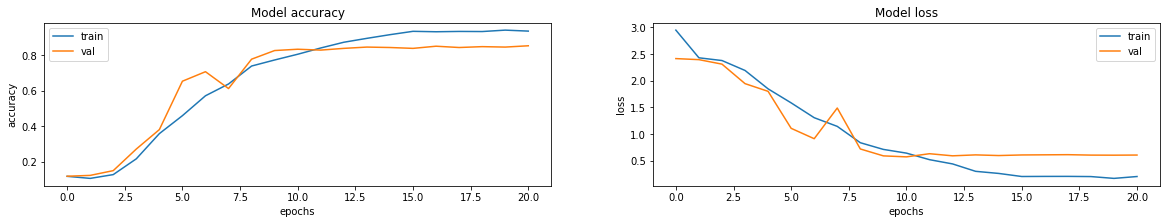

In [36]:
img_save_path = "./img/v3/"
ig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

if not(os.path.isdir(img_save_path)):
    os.makedirs(os.path.join(img_save_path))

img_name = img_save_path + "ANBWv3_acc_loss.png"
if not(os.path.isfile(img_name)):
    plt.savefig(img_name, facecolor="#eeeeee", bbox_inches="tight")

plt.show()